Goal: Build an image classifier using MobileNetV2 for disease detection in plants.

ML workflow — Data Prep → Model Building → Training → Evaluation → Saving.

Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!ls "/content/dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
!ls "/content/dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"


 Apple___Apple_scab
 Apple___Black_rot
 Apple___Cedar_apple_rust
 Apple___healthy
 Blueberry___healthy
'Cherry_(including_sour)___healthy'
'Cherry_(including_sour)___Powdery_mildew'
'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
'Corn_(maize)___Common_rust_'
'Corn_(maize)___healthy'
'Corn_(maize)___Northern_Leaf_Blight'
 Grape___Black_rot
'Grape___Esca_(Black_Measles)'
 Grape___healthy
'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)'
'Orange___Haunglongbing_(Citrus_greening)'
 Peach___Bacterial_spot
 Peach___healthy
 Pepper,_bell___Bacterial_spot
 Pepper,_bell___healthy
 Potato___Early_blight
 Potato___healthy
 Potato___Late_blight
 Raspberry___healthy
 Soybean___healthy
 Squash___Powdery_mildew
 Strawberry___healthy
 Strawberry___Leaf_scorch
 Tomato___Bacterial_spot
 Tomato___Early_blight
 Tomato___healthy
 Tomato___Late_blight
 Tomato___Leaf_Mold
 Tomato___Septoria_leaf_spot
'Tomato___Spider_mites Two-spotted_spider_mite'
 Tomato___Target_Spot
 Tomato___Tomato_mosaic_virus
 Tomato_

Data Preparation

In [ ]:
train_dir = '/content/dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
valid_dir = '/content/dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'


Preprocessing

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create ImageDataGenerator for training and validation
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)


Load the dataset from Drive and prepare it using ImageDataGenerator with augmentations and preprocessing for MobileNetV2.

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


Build the MobileNetV2 Model Use MobileNetV2 as the feature extractor, add custom layers on top, and compile the model.

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load the base model without the top layer
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,426,854 (9.26 MB)

 Trainable params: 168,870 (659.65 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Train the model

In [ ]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 216s 93ms/step - accuracy: 0.6375 - loss: 1.5450 - val_accuracy: 0.9027 - val_loss: 0.3492
Epoch 2/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 154s 70ms/step - accuracy: 0.9230 - loss: 0.2847 - val_accuracy: 0.9310 - val_loss: 0.2343
Epoch 3/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 156s 71ms/step - accuracy: 0.9469 - loss: 0.1897 - val_accuracy: 0.9427 - val_loss: 0.1857
Epoch 4/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 159s 72ms/step - accuracy: 0.9576 - loss: 0.1496 - val_accuracy: 0.9488 - val_loss: 0.1629
Epoch 5/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 157s 72ms/step - accuracy: 0.9650 - loss: 0.1235 - val_accuracy: 0.9509 - val_loss: 0.1519
Epoch 6/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 153s 70ms/step - accuracy: 0.9687 - loss: 0.1080 - val_accuracy: 0.9521 - val_loss: 0.1449
Epoch 7/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 154s 70ms/step - accuracy: 0.9733 - loss: 0.0962 - val_accuracy: 0.9560 - val_loss: 0.1338
Epoch 8/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 167s 76ms/step - accuracy: 

Checking accuracy using graph

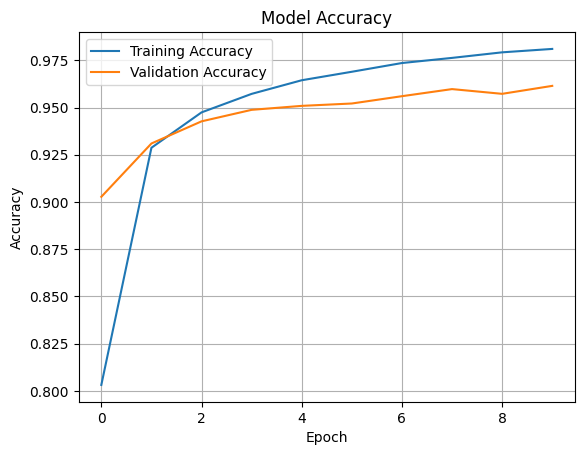

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
val_loss, val_accuracy = model.evaluate(valid_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


550/550 ━━━━━━━━━━━━━━━━━━━━ 32s 57ms/step - accuracy: 0.9611 - loss: 0.1172
Validation Accuracy: 96.15%


Accuracy and Loss graphs

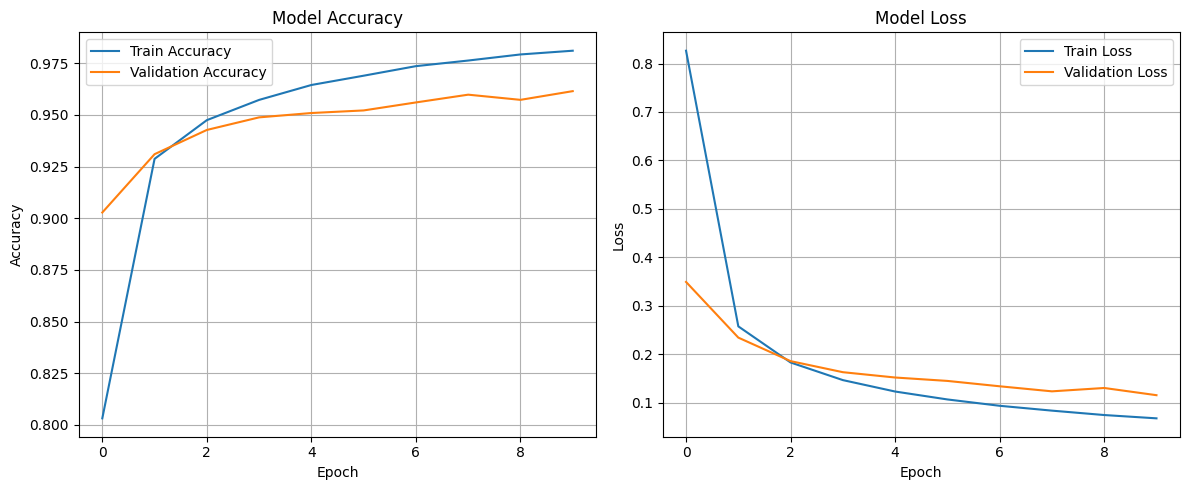

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/plant_disease_dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 17572 images belonging to 38 classes.


In [ ]:
model.evaluate(test_generator)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


550/550 ━━━━━━━━━━━━━━━━━━━━ 6167s 11s/step - accuracy: 0.9740 - loss: 0.0776


[0.11540840566158295, 0.9614728093147278]

Classification report

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predict the classes
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)


550/550 ━━━━━━━━━━━━━━━━━━━━ 69s 125ms/step
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.97      0.95      0.96       504
                                 Apple___Black_rot       0.98      0.99      0.98       497
                          Apple___Cedar_apple_rust       0.99      0.99      0.99       440
                                   Apple___healthy       0.99      0.97      0.98       502
                               Blueberry___healthy       0.99      0.99      0.99       454
          Cherry_(including_sour)___Powdery_mildew       0.99      0.99      0.99       421
                 Cherry_(including_sour)___healthy       0.97      1.00      0.98       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.91      0.93      0.92       410
                       Corn_(maize)___Common_rust_       1.00      0.99      0.99       477
               Corn_(maize)___North

Confusion matrix

<Figure size 1800x1800 with 0 Axes>

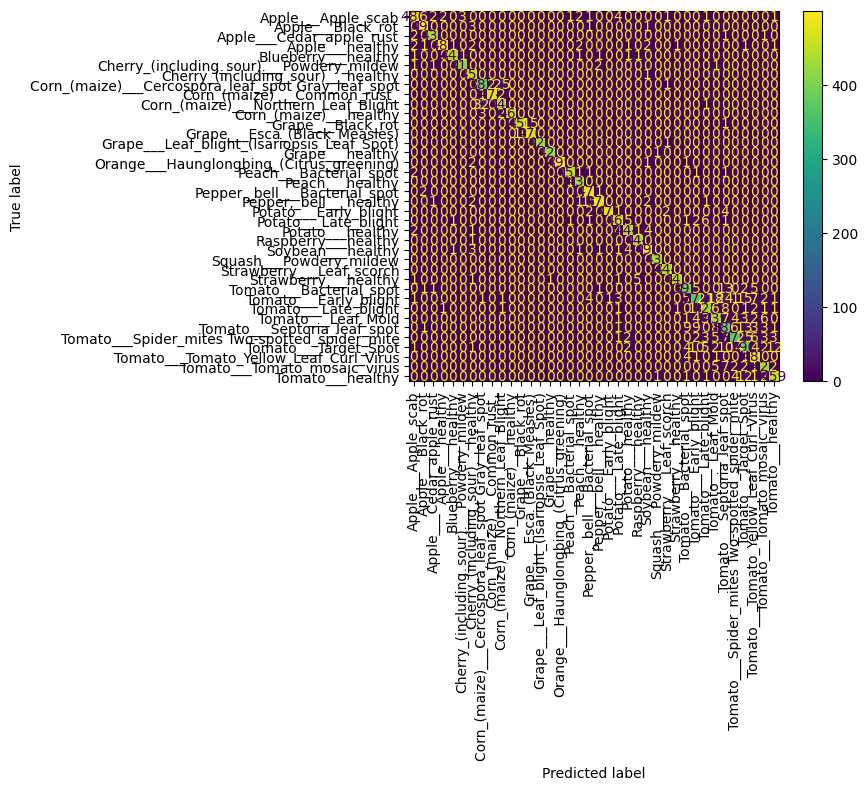

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming `true_classes` and `predicted_classes` are already defined
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

plt.figure(figsize=(18, 18))  # Set figure size here
disp.plot(xticks_rotation=90)
plt.show()


In [ ]:
import os

# Root where you saw 'New Plant Diseases Dataset(Augmented)'
root_path = '/content/drive/MyDrive/plant_disease_dataset'

# Dig deeper inside it
first_level = os.path.join(root_path, 'New Plant Diseases Dataset(Augmented)')
print("1st level contents:", os.listdir(first_level))

# Try going one level deeper again if needed
second_level = os.path.join(first_level, 'New Plant Diseases Dataset(Augmented)')
if os.path.exists(second_level):
    print("\n2nd level contents:", os.listdir(second_level))


1st level contents: ['New Plant Diseases Dataset(Augmented)']

2nd level contents: ['valid', 'train']


In [ ]:
from tensorflow.keras.models import load_model

model_path = "/content/drive/MyDrive/plant_disease_model.keras"
model = load_model(model_path)
print("✅ Model loaded successfully!")


✅ Model loaded successfully!


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
import os

# Actual path to Tomato___healthy folder
tomato_healthy_dir = "/content/drive/MyDrive/plant_disease_dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/Tomato___healthy"

# List images
image_files = os.listdir(tomato_healthy_dir)
print("Total images found:", len(image_files))
print("Example files:", image_files[:5])  # show a few images


Total images found: 481
Example files: ['2b21cbfc-9c23-42fb-984c-9439fa891a4c___RS_HL 9637_180deg.JPG', '0a0d6a11-ddd6-4dac-8469-d5f65af5afca___RS_HL 0555_180deg.JPG', '02b4afdf-e1de-4c0e-a38d-3f19afeb9ea9___RS_HL 0493_flipTB.JPG', '07776423-f0af-455c-a7c1-36215c7e7097___RS_HL 0321.JPG', '00bce074-967b-4d50-967a-31fdaa35e688___RS_HL 0223_flipTB.JPG']


In [ ]:
img_path = "/content/drive/MyDrive/plant_disease_dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/Tomato___healthy/2b21cbfc-9c23-42fb-984c-9439fa891a4c___RS_HL 9637_180deg.JPG"


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
predictions = model.predict(img_array)
predicted_class = class_names[np.argmax(predictions)]
confidence = np.max(predictions)

print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Class: Tomato___healthy
Confidence: 0.64


Prediction on healthy leaf

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


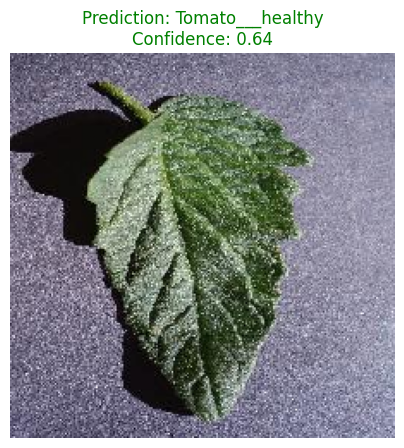

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array_expanded = np.expand_dims(img_array, axis=0)

# Make prediction
predictions = model.predict(img_array_expanded)
predicted_class = class_names[np.argmax(predictions)]
confidence = np.max(predictions)

# Plotting
plt.figure(figsize=(5, 5))
plt.imshow(img_array)
plt.axis('off')
plt.title(f"Prediction: {predicted_class}\nConfidence: {confidence:.2f}", fontsize=12, color='green')
plt.show()


In [ ]:
valid_path = "/content/drive/MyDrive/plant_disease_dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"


In [ ]:
import os

all_classes = os.listdir(valid_path)
tomato_classes = [cls for cls in all_classes if "Tomato" in cls]
print("Tomato-related classes found:")
print(tomato_classes)


Tomato-related classes found:
['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Target_Spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


Load model

In [ ]:
from tensorflow.keras.models import load_model

# Mount Google Drive if not already
from google.colab import drive
drive.mount('/content/drive')

# Load the trained model
model_path = "/content/drive/MyDrive/plant_disease_model.keras"
model = load_model(model_path)

print("✅ Model loaded successfully!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model loaded successfully!


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Define the path to your valid dataset
valid_path = "/content/drive/MyDrive/plant_disease_dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"

# Get the class names (folder names)
class_names = sorted(os.listdir(valid_path))

print("✅ Class names loaded:", class_names)


✅ Class names loaded: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite

Prediction on unhealthy plant

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


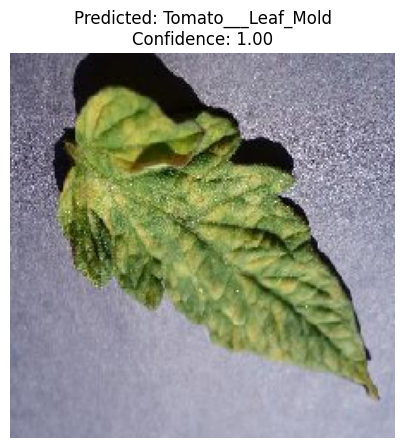

In [ ]:
pred = model.predict(img_array_expanded)[0]
predicted_class = class_names[np.argmax(pred)]
confidence = np.max(pred)

# Plot image with predicted class and confidence
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.axis("off")
plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}")
plt.show()


Prediction on multiple images

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Set valid dataset path
valid_path = "/content/drive/MyDrive/plant_disease_dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"

# Load class names
class_names = sorted(os.listdir(valid_path))

# Select number of images you want to predict
num_images = 9

# Collect image paths from random classes
image_paths = []
for _ in range(num_images):
    class_folder = random.choice(class_names)
    class_path = os.path.join(valid_path, class_folder)
    img_file = random.choice(os.listdir(class_path))
    image_paths.append((os.path.join(class_path, img_file), class_folder))

# Predict and plot
plt.figure(figsize=(15, 15))
for idx, (img_path, actual_class) in enumerate(image_paths):
    # Load and preprocess
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array_expanded = np.expand_dims(img_array, axis=0)

    # Predict
    pred = model.predict(img_array_expanded)[0]
    predicted_class = class_names[np.argmax(pred)]
    confidence = np.max(pred)

    # Plot
    plt.subplot(3, 3, idx+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Pred: {predicted_class}\nConf: {confidence:.2f}", fontsize=10)

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

Saving the model

In [ ]:
model.save("/content/drive/MyDrive/plant_disease_model2.keras")
